# Lecture 22

This lecture introduces reactor design for systems involving multiple reactions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Example Problem 01

**Rawlings, Example 4.5**:

You are carrying out Benzene Pyrolysis in a Plug Flow Reactor operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and ***follow elementary rate laws***.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

If pure benzene is fed into the reactor at 60,000 moles per hour, find the PFR volume required to achieve 50\% conversion of Benzene.  Also, plot the mole fraction of each species as a function of PFR volume.

**Answer**: 403.3 L

### Solution to Example Problem 01

Even though there are multiple reactions, we approach this problem the same way as usual: we write a material balance on Benzene.

$$\frac{dF_B}{dV} = R_B$$

We generally know that $R_B$ is going to be a complex function of concentrations of all of the species present in this system.  That means we can't solve the above balance on Benzene without also solving balances on Diphenyl, Hydrogen, and Triphenyl *at the same time*, i.e., we have to solve the coupled system of differential equations below:

\begin{align}
    \frac{dF_B}{dV} &= R_B \\
    \frac{dF_D}{dV} &= R_D \\
    \frac{dF_H}{dV} &= R_H \\
    \frac{dF_T}{dV} &= R_T \\
\end{align}

So, we've got 4 differential equations that tell us how 4 dependent variables ($F_B$, $F_D$, $F_H$, $F_T$) change as a function of the one independent variable, V.  We can solve this system *if* we can define everything on the right hand sides of the above equations ($R_B$, $R_D$, $R_H$, and $R_T$) in terms of $F_B$, $F_D$, $F_H$, $F_T$, and/or $V$.

We know how to do this!!

Generally:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r1 - r2 \\
    R_D &=  r1 - r2 \\
    R_H &=  r2 + r2 \\
    R_T &=  r2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$F_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, Q, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define Q in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

With that, we've defined out system of ODES fully as a function of molar flowrates and reactor volume.  We can solve this numerically using solve_ivp.  See below


In [2]:
def MR01(vol, var):
    
    #Dependent variables are all in var
    FB = var[0]
    FD = var[1]
    FH = var[2]
    FT = var[3]
    
    #Constants from problem statement
    T   = 1033    #K
    P   = 1.0     #atm
    R   = 0.08206 #L*atm/mol/K
    k1f = 7.0e5   #L/mol/h
    k2f = 4.0e5   #L/mol/h
    KC1 = 0.31
    KC2 = 0.48
    k1r = k1f/KC1 #L/mol/h
    k2r = k2f/KC2 #L/mol/h=
    
    #total molar flowrate, function of individual molar flowrates
    FTOT = FB + FD + FH + FT
    
    #volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #now that we have concentrations, we define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #With reaction rates, you can define production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #For a PFR, dFj/dV = Rj, so these are our derivatives of FB, FD, FH, FT
    D1   = RB
    D2   = RD
    D3   = RH
    D4   = RT
    
    #return derivatives of each dependent variable w.r.t. volume
    return [D1, D2, D3, D4]

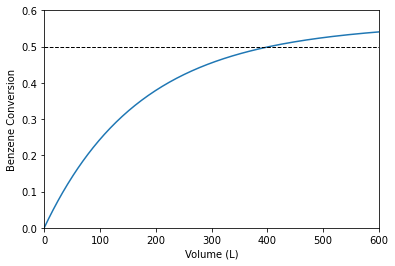

The Volume required to achive 50% Benzene conversion is 403.3L


In [3]:
#This cell solves the ODE system (an initial value problem) using solve_ivp
FBf     = 60000 #mol/h
FDf     = 0
FHf     = 0
FTf     = 0

#Solve the problem
vspan   = (0, 600)
var0    = [FBf, FDf, FHf, FTf]
solMR01 = solve_ivp(MR01, vspan, var0, atol = 1e-12, rtol = 1e-12)

#Extract data from the solution structure.
Vout    = solMR01.t
FBout   = solMR01.y[0]

#Calculate conversion
XBout   = (FBf - FBout)/FBf

#Plot conversion vs. reactor volume.
plt.plot(Vout, XBout)
plt.xlim(0, max(vspan))
plt.ylim(0, 0.6)
plt.hlines(0.5, 0, max(vspan), linestyle = 'dashed', color = 'black', linewidth = 1)
plt.xlabel('Volume (L)')
plt.ylabel('Benzene Conversion')
plt.show()

#Create an interpolating polynomial f(XB) = V
itp01   = interp1d(XBout, Vout, kind = 'cubic')
print(f'The Volume required to achive 50% Benzene conversion is {itp01(0.5):3.1f}L')

Now we extract all of the molar flowrates so we can calculate mole fractions as a function of reactor volume.

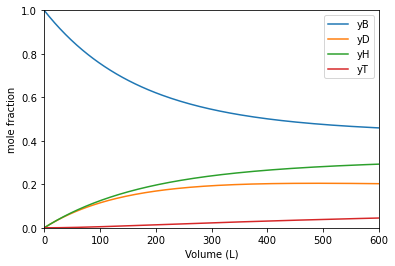

In [4]:
#Molar flowrates as a function of volume.
FBout   = solMR01.y[0]
FDout   = solMR01.y[1]
FHout   = solMR01.y[2]
FTout   = solMR01.y[3]

#Sum things up to get the total molar flowrate as a function of volume.
FTot_o  = FBout + FDout + FHout + FTout

#Calculate mole fractions as a function of volume.
yBout   = FBout/FTot_o
yDout   = FDout/FTot_o
yHout   = FHout/FTot_o
yTout   = FTout/FTot_o

#Plot mole fractions vs. volume
plt.plot(Vout, yBout, label = 'yB')
plt.plot(Vout, yDout, label = 'yD')
plt.plot(Vout, yHout, label = 'yH')
plt.plot(Vout, yTout, label = 'yT')
plt.xlim(0, max(vspan))
plt.ylim(0, 1)
plt.xlabel('Volume (L)')
plt.ylabel('mole fraction')
plt.legend()
plt.show()

## Example Problem 02

**Rawlings, Example 4.5 in a CSTR**:

You are carrying out Benzene Pyrolysis in a CSTR operating at 1033K and 1.0 atm.  The two reactions occurring in this system are benzene coupling to form diphenyl and hydrogen followed by a secondary reaction between benzene and diphenyl to form triphenyl and hydrogen:

\begin{align*}
&2B \longleftrightarrow D + H_2\\
&B + D \longleftrightarrow T + H_2
\end{align*}

Both reactions are reversible and follow elementary rate laws.  Rate constants and equilibrium concentration ratios ($K_C$) are given below.

\begin{align*}
&k_1 = 7.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&k_2 = 4.0 \ \times 10^5 \ \textrm{L} \ \textrm{mol}^{-1} \ \textrm{h}^{-1}\\
&K_{C_1} = 0.31\\
&K_{C_2} = 0.48
\end{align*}

If pure benzene is fed into the reactor at 60,000 moles per hour, find the CSTR volume required to achieve 50\% conversion of Benzene.  Also, plot the mole fraction of each species as a function of CSTR volume.

**Answer**: 1315.6 L; see graphs for mole fraction plots	

### Solution to Example Problem 02

If we consider a material balance on Benzene in a CSTR at steady state:

$$0 = F_{B,f} - F_B + R_BV$$

I can see that the term $R_B$ actually will depend on the concentrations of diphenyl, triphenyl, and hydrogen (see the PFR discussion above).  So I won't be able to solve this equation by itself.  I'll need to somehow determine the concentrations of all species...

The easiest way to do this is to recognize that we can write a single, independent balance for each component:

\begin{align}
    0 = F_{B,f} - F_B + R_BV \\
    0 = F_{D,f} - F_D + R_DV \\
    0 = F_{H,f} - F_H + R_HV \\
    0 = F_{T,f} - F_T + R_TV \\
\end{align}

The way I view this is that I have four equations written in terms of five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$).  I say this because although I don't "know" the production rates for each species, $R_j$, I can express all of those production rates in terms of species flow rates.

I need to do two things.  First, I need to add another equation to this system since I have an additional unknown (Volume).  I'll do that from the conversion specification.

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
    0 &= X_B - 0.5 \\
\end{align}

Now, I just have to make sure everything on the right hand side of those equations is expressed as functions of my five unknowns ($F_B$, $F_D$, $F_H$, $F_T$, and $V$).  We do this pretty much the same was as we do in the PFR case.  Starting with species production rates:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r1 - r2 \\
    R_D &=  r1 - r2 \\
    R_H &=  r2 + r2 \\
    R_T &=  r2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$F_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, Q, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define Q in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

We set this up below for solution with opt.root--five equations and five unknowns.

In [5]:
def MR02(var):
    
    #unknowns in the array var
    FB = var[0]
    FD = var[1]
    FH = var[2]
    FT = var[3]
    V  = var[4]
    
    #Parameters from problem statement
    T   = 1033    #K
    P   = 1.0     #atm
    R   = 0.08206 #L*atm/mol/K
    k1f = 7.0e5   #L/mol/h
    k2f = 4.0e5   #L/mol/h
    KC1 = 0.31
    KC2 = 0.48
    k1r = k1f/KC1 #L/mol/h
    k2r = k2f/KC2 #L/mol/h
    FBf = 60000   #mol/h
    FDf = 0
    FHf = 0
    FTf = 0
                
    #Total molar flowrate
    FTOT = FB + FD + FH + FT
    
    #Volumetric flowrate
    Q    = FTOT*R*T/P
    
    #Define species concentrations
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    #Define reaction rates
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    #Define species production rates
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    #Define fractional conversion
    XB   = (FBf - FB)/FBf
    
    #Write the five equations to be solved.
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    F3   = FHf - FH + RH*V
    F4   = FTf - FT + RT*V
    F5   = 0.5 - XB

    #Return the left hand side of each of the five constraint equations
    #When the problem is solved, these should all be zero.
    return [F1, F2, F3, F4, F5]

In [6]:
#Solve the system of equations using opt.root

#We need to provide initial guesses for each of our unknowns (FB, FD, FH, FT, V)
var0    = (FBf/2, FBf/2, FBf/2, FBf/2, 1000)
solMR02 = opt.root(MR02, var0)
print(solMR02.x)

#Where volume is given by
solMR02.x[4]

[30000.          9769.00421991 16743.66526003  3487.33052006
  1315.62036749]


1315.620367487792

### Alternate Solution to Example Problem 02 

Fundamentally, there is nothing wrong with the approach above, where we wrote a material balance on each species to solve the problem.

Sometimes, when solving algebraic problems with numerical methods (like opt.root), it is very difficult for the solver to converge.  This is because a) solving algebraic equations numerically is challenging; b) solving the system gets more challenging when we write more equations; and c) we need to provide a good initial guess as to *what the correct solution is*.  Otherwise, the problem will not usually converge.

It can be useful to reduce the number of equations and unknowns that we're tying to solve.  We can do this by taking an alternate approach.  Specifically, instead of describing the system in terms of molar flowrates for all species (and volume), which gives us five unkowns, we can decide to instead express the system in terms of one extent of reaction for each reaction occuring and the system volume.  If we do this, we get to write one extent per chemical reaction, and we get to write one material balance for each reaction.

So, above we wrote the following five equations:

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= F_{H,f} - F_H + R_HV \\
    0 &= F_{T,f} - F_T + R_TV \\
    0 &= X_B - 0.5 \\
\end{align}

And we are able to express all of the production rates in terms of molar flowrates.  Here, we'll express each exit flowrate in terms of extents of reaction (as we would do in a mole table):

\begin{align}
    F_B &= F_{B,f} - 2\varepsilon_1 - \varepsilon_2 \\
    F_D &= F_{D,f} + \varepsilon_1 - \varepsilon_2 \\
    F_H &= F_{H,f} + \varepsilon_1 + \varepsilon_2 \\
    F_T &= F_{T,f} + \varepsilon_2 \\
\end{align}

By doing this, we reduce the system to 3 unknowns ($\varepsilon_1$, $\varepsilon_2$, and $V$).  Therefore, we only get to write 3 equations.  When we express the system in terms of extents, we get to write one balance per reaction instead of one balance per species.  I can arbitrarily pick two independent balance equations.  I will keep the specification that fractional conversion is 50% as my third equation.  That gives me:

\begin{align}
    0 &= F_{B,f} - F_B + R_BV \\
    0 &= F_{D,f} - F_D + R_DV \\
    0 &= X_B - 0.5 \\
\end{align}

Where, in this case, I just have to make sure to express everything on the right hand side of these equations in terms of ($\varepsilon_1$, $\varepsilon_2$, and $V$). We do this as usual:

$$R_j = \sum_i \nu_{i,j} r_i$$

So:

\begin{align}
    R_B &= -2r1 - r2 \\
    R_D &=  r1 - r2 \\
    R_H &=  r2 + r2 \\
    R_T &=  r2 \\
\end{align}

We next define reaction rates:

\begin{align}
    r_1 &= k_{1,f}C_B^2 - k_{1,r}C_HC_D \\
    r_2 &= k_{2,f}C_BC_D - k_{2,r}C_HC_T \\
\end{align}

We define concentrations in terms of molar flowrates:

$$F_j = \frac{F_j}{Q}$$

Which throws a volumetric flowrate, Q, into the mix.  Fortunately, this is a gas phase reaction at low pressure, so we know we can define Q in terms of the total molar flowrate:

$$Q = \frac{F_{tot}RT}{P}$$

Where

$$F_{tot} = \sum_j F_j$$

If you go back and trace through all of these definitions, you'll see that everything on the right hand side of our three equations is expressed in terms of either constants or our three unknowns. 

In [7]:
def MR03(var):
    #Unknowns
    e1  = var[0]
    e2  = var[1]
    V   = var[2]
    
    #Unknowns
    T   = 1033    #K
    P   = 1.0     #atm
    R   = 0.08206 #L*atm/mol/K
    k1f = 7.0e5   #L/mol/h
    k2f = 4.0e5   #L/mol/h
    KC1 = 0.31
    KC2 = 0.48
    k1r = k1f/KC1 #L/mol/h
    k2r = k2f/KC2 #L/mol/h
    FBf = 60000   #mol/h
    FDf = 0
    FHf = 0
    FTf = 0
    
    FB   = FBf - 2*e1 - 1*e2
    FD   = FDf + 1*e1 - 1*e2
    FH   = FHf + 1*e1 + 1*e2
    FT   = FTf + 0*e1 + 1*e2
    
    FTOT = FB + FD + FH + FT
    Q    = FTOT*R*T/P
    
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    XB   = (FBf - FB)/FBf
    
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    F3   = 0.5 - XB
    
    return [F1, F2, F3]

In [8]:
#Now we solve the system of 3 equations/3 unknowns

var0    = (20000, 10000, 1000)
solMR03 = opt.root(MR03, var0)
solMR03

    fjac: array([[-8.41636059e-01,  5.40045132e-01,  2.51344552e-06],
       [-5.40045132e-01, -8.41636059e-01,  4.46730782e-06],
       [-4.52795422e-06, -2.40247333e-06, -1.00000000e+00]])
     fun: array([-6.31771400e-08,  8.97707650e-08, -1.11022302e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-2.40952836e-04,  9.79760003e-05, -1.67932875e-10])
       r: array([-1.32620072e+01, -1.28304668e+00,  2.52908371e+01, -3.00892595e+00,
        5.21408349e+00,  8.68600570e-05])
  status: 1
 success: True
       x: array([13256.33473996,  3487.33052008,  1315.62036749])

### Obtaining Mole Fractions as a function of CSTR Volume

As a final point, we still want to plot the mole fraction of products as a function of reactor volume.  For a CSTR, we solve one fractional conversion at one volume in the set of algebraic equations above.  If we want to solve for many volumes, we'll have to solve the set of algebraic equations for every volume we're interested in.  I do this below by passing a "current" volume into the system of equations, and solving it for many volumes using a for loop.  The key thing to note is that I will specify volume and solve for the two extents at that volume, so I'm down to two unknowns.

In [9]:
def MR04(var, V):
    #Unknowns
    e1  = var[0]
    e2  = var[1]
    
    #Parameters and constants from problem statement.
    T   = 1033    #K
    P   = 1.0     #atm
    R   = 0.08206 #L*atm/mol/K
    k1f = 7.0e5   #L/mol/h
    k2f = 4.0e5   #L/mol/h
    KC1 = 0.31
    KC2 = 0.48
    k1r = k1f/KC1 #L/mol/h
    k2r = k2f/KC2 #L/mol/h
    FBf = 60000   #mol/h
    FDf = 0
    FHf = 0
    FTf = 0
    
    FB   = FBf - 2*e1 - 1*e2
    FD   = FDf + 1*e1 - 1*e2
    FH   = FHf + 1*e1 + 1*e2
    FT   = FTf + 0*e1 + 1*e2
    
    FTOT = FB + FD + FH + FT
    Q    = FTOT*R*T/P
    
    CB   = FB/Q
    CD   = FD/Q
    CH   = FH/Q
    CT   = FT/Q
    
    r1   = k1f*CB**2 - k1r*CD*CH
    r2   = k2f*CB*CD - k2r*CT*CH
    
    RB   = -2*r1 - r2
    RD   =    r1 - r2
    RH   =    r1 + r2
    RT   =         r2
    
    XB   = (FBf - FB)/FBf
    
    #Constraint equations
    F1   = FBf - FB + RB*V
    F2   = FDf - FD + RD*V
    
    return [F1, F2]

So, with the above function defined, I can pass it a value of volume, and I can solve for the two extents of reaction at that volume.  I do this by passing the volume as an extra parameter with a lambda function. See below where I solve the above for 1000L.  Although it looks complicated, this is effectively the same as writing:

    V = 1000

in the middle of my MR04 function.

In [10]:
vol     = 1000
var0    = [1000, 1000] #initial guess for solution of e1 and e2
objtemp = lambda var: MR04(var, vol)
tempsol = opt.root(objtemp, var0)
tempsol.x #This is the extent of reactions (e1 and e2) for V = 1000L

array([12836.64907302,  3104.40964972])

Well, if we can do that for one volume, we can do it for 100 volumes.  We'll set up a loop for this.

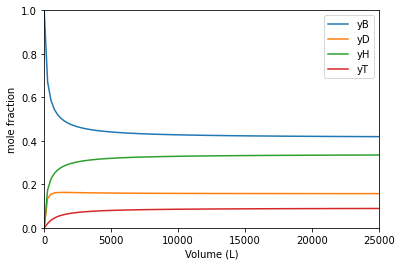

In [11]:
#Create a list of volumes we're interested in solving, we'll just go from 1 to 25000L
#We'll do this in 100 elements.  Basically, we're going to have to solve the above system for 100 different volumes.
V       = np.linspace(1, 25000, 100)
extent  = np.zeros((len(V), 2))

for i, vol in enumerate(V): 
    obj02   = lambda var: MR04(var, vol)
    var0    = (10000, 10000)
    solMR04 = opt.root(obj02, var0)
    extent[i,:]  = solMR04.x
extent

FB = FBf - 2*extent[:,0] - 1*extent[:,1]
FD = FDf + 1*extent[:,0] - 1*extent[:,1]
FH = FHf + 1*extent[:,0] + 1*extent[:,1]
FT = FTf + 0*extent[:,0] + 1*extent[:,1]
FTot = FB + FD + FH + FT
yB   = FB/FTot
yD   = FD/FTot
yH   = FH/FTot
yT   = FT/FTot

plt.plot(V, yB, label = 'yB')
plt.plot(V, yD, label = 'yD')
plt.plot(V, yH, label = 'yH')
plt.plot(V, yT, label = 'yT')
plt.xlim(0, max(V))
plt.ylim(0, 1)
plt.xlabel('Volume (L)')
plt.ylabel('mole fraction')
plt.legend()
plt.show()

As a reminder of the significance of chemical equilibrium in these systems, we see that the composition stops changing after a certain reactor size.  At this point, we've reached equilibrium.  You can see this by comparing the value of the reaction quotient to the equilibrium constant.  The system is approaching equilibrium as the reaction reaches 15000L, and if we make the reactor much larger, the extra volume won't be useful for increasing conversion since the system is basically equilibrated and no further conversion is possible.

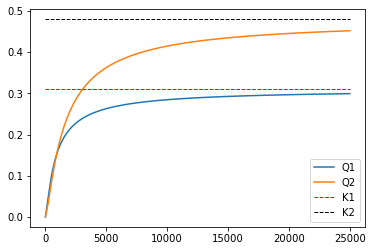

In [12]:
T   = 1033    #K
P   = 1.0     #atm
R   = 0.08206 #L*atm/mol/K
CB = yB*P/R/T #This is the ideal gas law, believe it or not.
CD = yD*P/R/T
CH = yH*P/R/T
CT = yT*P/R/T

Q1 = CD*CH/CB**2 #This is the right hand side of K_C = product(C_j^\nu_j) for rxn 1
Q2 = CT*CH/CD/CB #This is the right hand side of K_C = product(C_j^\nu_j) for rxn 2

plt.figure(1)
plt.plot(V, Q1, label = 'Q1')
plt.plot(V, Q2, label = 'Q2')
plt.hlines(0.31, 0, max(V), linestyle = 'dashed', linewidth = 1, color = 'red', label = 'K1')
plt.hlines(0.48, 0, max(V), linestyle = 'dashed', linewidth = 1, color = 'black', label = 'K2')
plt.legend(loc = 'lower right')
plt.show()